# Simple jupyter notebook for accesing TimescaleDB database via kubectl port forward for SQL query

*Aniket Pant, UIUC*

In [40]:
import os

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from datetime import datetime, timedelta

In [41]:
# Build a SQLAlchemy engine using Postgres connection details from the environment.
db_url = URL.create(
    "postgresql+psycopg2",
    username=os.getenv("POSTGRES_USER", "ships"),
    password=os.getenv("POSTGRES_PASSWORD", "ships"),
    host=os.getenv("POSTGRES_HOST", "localhost"),
    port=int(os.getenv("POSTGRES_PORT", 5432)),
    database=os.getenv("POSTGRES_DB", "ships"),
)

engine = create_engine(db_url, future=True)

with engine.connect() as connection:
    df = pd.read_sql(text("SELECT NOW() AS server_time"), connection)

In [42]:
df # cool - server connectionw works!

,server_time
0,2025-10-08 17:44:53.622243+00:00


In [43]:
from sqlalchemy import text

with engine.connect() as conn:
    total = conn.execute(text("SELECT COUNT(*) FROM public.ship_positions")).scalar_one()
    print(f"rows in public.ship_positions: {total:,}") # how many rows do we have in our table currently? this should be pretty fast in timescaleDB

rows in public.ship_positions: 14,017,899


In [51]:
import gzip
from sqlalchemy import text

min_lon, min_lat = -11.0, 30.0
max_lon, max_lat =  40.0, 72.0
day = datetime(2025, 9, 15)
t0 = day.replace(hour=0, minute=0, second=0, microsecond=0)
t1 = t0 + timedelta(days=31)

params = {
    "t0": t0,
    "t1": t1,
    "min_lon": min_lon, "min_lat": min_lat,
    "max_lon": max_lon, "max_lat": max_lat,
}

with engine.begin() as conn:
    raw = conn.connection
    cur = raw.cursor()

    cur.execute("SET statement_timeout = '0'")
    cur.execute("SET max_parallel_workers_per_gather = 0")
    cur.execute("SET parallel_leader_participation = off")

    sql = """
    COPY (
      WITH env AS (SELECT ST_MakeEnvelope(%s, %s, %s, %s, 4326) AS e)
      SELECT mmsi, ts, ST_X(geom) AS lon, ST_Y(geom) AS lat
      FROM public.ship_positions, env
      WHERE ts >= %s AND ts < %s
        AND geom && e
        AND ST_Intersects(geom, e)
    ) TO STDOUT WITH (FORMAT csv, HEADER true)
    """

    # Order of params must match the %s placeholders above
    args = (
        params["min_lon"], params["min_lat"],
        params["max_lon"], params["max_lat"],
        params["t0"], params["t1"],
    )

    sql_lit = cur.mogrify(sql, args).decode("utf-8")

    with gzip.open("europe_slice.csv.gz", "wt", newline="") as f:
        cur.copy_expert(sql_lit, f)

    cur.close()

In [52]:
full_df = pd.read_csv("europe_slice.csv.gz")

In [53]:
full_df.head()

,mmsi,ts,lon,lat
0,205527690,2025-09-29 07:36:54+00,3.237887,51.295008
1,226002150,2025-09-29 07:44:56+00,3.206312,51.296040
2,205527690,2025-09-29 11:35:49+00,3.237618,51.295593
3,226002150,2025-09-29 11:40:02+00,3.207227,51.291930
4,244700012,2025-09-29 11:41:34+00,3.237857,51.296860


In [54]:
full_df.shape

(10343277, 4)

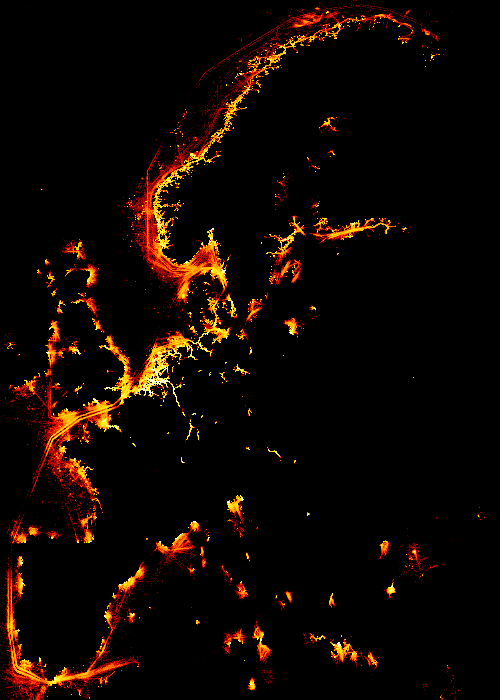

In [58]:
# pip install datashader colorcet
import datashader as ds
import datashader.transfer_functions as tf
import colorcet as cc

# Canvas sized to taste; clip to your bbox for speed
cvs = ds.Canvas(
    plot_width=500, plot_height=700,
    x_range=(min_lon, max_lon), y_range=(min_lat, max_lat)
)

# Aggregate: point density
agg = cvs.points(full_df, x="lon", y="lat", agg=ds.count())

# Colorize
img = tf.shade(agg, cmap=cc.fire, how="eq_hist")
img = tf.set_background(img, "black")

img

In [60]:
img.to_pil().save("europe_slice.png")

                        day  ships   points
0 2025-09-29 00:00:00+00:00  19254   109276
1 2025-09-30 00:00:00+00:00  24111  1164748
2 2025-10-01 00:00:00+00:00  24301  1175283
3 2025-10-02 00:00:00+00:00  24285  1174384
4 2025-10-03 00:00:00+00:00  23795  1168993
5 2025-10-04 00:00:00+00:00  22373  1170190
6 2025-10-05 00:00:00+00:00  22072  1169060
7 2025-10-06 00:00:00+00:00  23693  1170310
8 2025-10-07 00:00:00+00:00  24061  1166106
9 2025-10-08 00:00:00+00:00  22864   881858


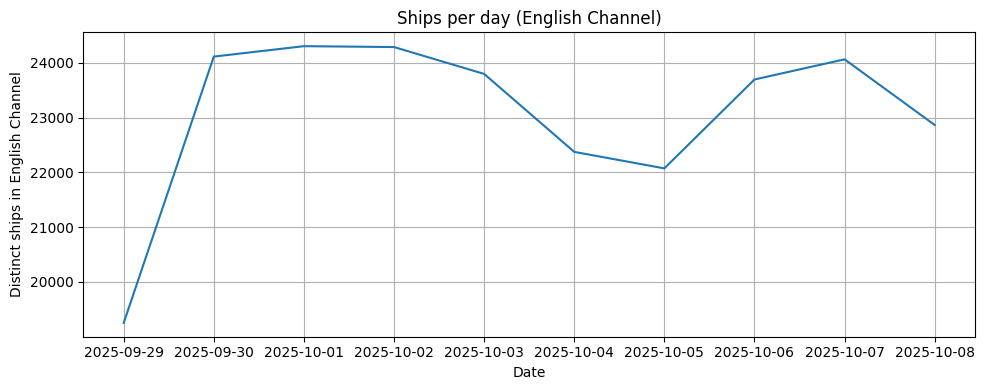

In [61]:
SQL = text("""
WITH box AS (
  SELECT ST_MakeEnvelope(:min_lon, :min_lat, :max_lon, :max_lat, 4326) AS env
)
SELECT
  date_trunc('day', ts) AS day,
  COUNT(DISTINCT mmsi) AS ships,   -- unique ships per day
  COUNT(*) AS points               -- total AIS points (optional, useful for QA)
FROM public.ship_positions, box
WHERE ts >= :t0 AND ts < :t1
  AND geom && env
  AND ST_Intersects(geom, env)
GROUP BY 1
ORDER BY 1
""")

df_daily = pd.read_sql_query(SQL, engine, params=params, parse_dates=["day"])
print(df_daily)

# Line plot: day vs distinct ships
plt.figure(figsize = (10,4))
plt.plot(df_daily["day"], df_daily["ships"])
plt.xlabel("Date")
plt.ylabel("Distinct ships in English Channel")
plt.title("Ships per day (English Channel)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
%timeit df_daily = pd.read_sql_query(SQL, engine, params=params, parse_dates=["day"])

15.8 s ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
